# ${\color{pink}\mathbb{Frozen-Lake-Matala-1}}$

# ${\color{cyan}{\text{Reinforcement Learning -------- למידה באמצעות חיזוקים }}}$

##### ${\color{yellow}\mathbb{Matan-Ginzburg}}$

##### ${\color{yellow}\mathbb{Value-Iteration-And-Policy-Iteration}}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.spaces import Discrete, Tuple

import pygame
import time
from pprint import pprint
from matplotlib.colors import to_rgb
from matplotlib.colors import to_rgba_array


##### ${\color{pink}\mathbb{Set-Lake}}$

In [3]:
class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, map_name="4x5", is_slippery=True, slip_prob=0.2):
        self.map_name = map_name
        self.is_slippery = is_slippery
        self.slip_prob = slip_prob

        self.desc = np.asarray([            #custom map...
                            "SFFFF",
                            "FFFFH",
                            "FFHFF",
                            "FFFFG"
                                ], dtype="c")

        self.nrow, self.ncol = self.desc.shape
        self.nA = 4
        self.nS = self.nrow * self.ncol

        self.P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        self._init_transitions()

        self.observation_space = Discrete(self.nS)
        self.action_space = Discrete(self.nA)

        self.reset()

    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == 0:  # left
            col = max(col - 1, 0)
        elif a == 1:  # down
            row = min(row + 1, self.nrow - 1)
        elif a == 2:  # right
            col = min(col + 1, self.ncol - 1)
        elif a == 3:  # up
            row = max(row - 1, 0)
        return (row, col)

    def _init_transitions(self):
        for row in range(self.nrow):
            for col in range(self.ncol):
                s = self.to_s(row, col)
                for a in range(self.nA):
                    li = self.P[s][a]
                    letter = self.desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if self.is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                newrow, newcol = self.inc(row, col, b)
                                newstate = self.to_s(newrow, newcol)
                                newletter = self.desc[newrow, newcol]
                                done = bytes(newletter) in b"GH"
                                rew = self.get_tile_reward(newletter)       #to change for custom rewards...
                                prob = (
                                    self.slip_prob / 2 if b != a else 1 - self.slip_prob
                                )
                                li.append((prob, newstate, rew, done))
                        else:
                            newrow, newcol = self.inc(row, col, a)
                            newstate = self.to_s(newrow, newcol)
                            newletter = self.desc[newrow, newcol]
                            done = bytes(newletter) in b"GH"
                            rew = float(newletter == b"G")
                            li.append((1.0, newstate, rew, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = 0
        return self.s, {}

    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, s, rew, done = transitions[i]
        self.s = s
        return s, rew, done, False, {}
    
    def get_tile_reward(self,tile):
    
        if tile == b'S':
            return -0.08  
        elif tile == b'F':
            return -0.08  
        elif tile == b'H':
            return -1.0
        elif tile == b'G':
            return 1.0
        else:
            return -10  
    

In [4]:
gym.envs.registration.register(
        id="CustomFrozenLake-v0",
        entry_point=__name__ + ":CustomFrozenLakeEnv",
    )

# ${\color{pink}\mathbb{Value-Iterations}}$

##### ${\color{pink}\mathbb{Prepiratuon}}$

$$ Q_i(s, a) = \sum_{s'} P(s' \mid s, a) \cdot \left[ r(s, a, s') + \gamma V_i(s') \right] $$

$$ V_{i+1}(s) = \max_a \sum_{s'} P(s' \mid s, a) \cdot \left[ r(s, a, s') + \gamma V_i(s') \right] = \max_a Q_i(s, a) $$

$$ \pi^*(s) = \arg\max_a \sum_{s'} P(s' \mid s, a) \cdot \left[ r(s, a, s') + \gamma V_i(s') \right] = \arg\max_a Q_i(s, a) $$

In [5]:
def get_action_value(P, V, state, action, gamma):   #Q

    q = 0
    for prob, next_state, reward, done in P[state][action]:
        q += prob * (reward + gamma * V[next_state])
        
    return q


def get_new_state_value(P, V, state, actions, gamma): #V_i+1

    q_values = [get_action_value(P, V, state, a, gamma) for a in actions]

    return max(q_values)


def get_optimal_action(P, V, state, actions, gamma=0.9):

    q_values = [get_action_value(P, V, state, a, gamma) for a in actions]

    return np.argmax(q_values)

#### ${\color{pink}\mathbb{Value - Iterations:}}$

In [6]:
def value_iteration(P, n_states, n_actions, gamma=0.9, threshold=1e-6,num_iterations=100000):
    V = np.zeros(n_states)
    #V = np.array([get_tile_reward(desc[s // w][s % w]) for s in range(n_states)])

    for i in range(num_iterations):
        delta = 0
        new_V = np.zeros(n_states)
        for s in range(n_states):
            v_old = V[s]
            v_new = get_new_state_value(P, V, s, n_actions, gamma)
            #v_new = get_new_state_value(P, V, s, list(range(n_actions)), gamma)

            new_V[s] = v_new
            delta = max(delta, abs(v_old - v_new))
        V = new_V
        if delta < threshold:
            break
    return V

----

In [7]:
env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)

P = env.unwrapped.P
n_states = env.observation_space.n    
n_actions = env.action_space.n


actions = list(range(n_actions))
V = value_iteration(P, n_states, actions, gamma=0.9, threshold=1e-6)

#policy = get_optimal_action(P, V, n_states, actions, gamma=0.9)
policy = np.array([
    get_optimal_action(P, V, s, actions, gamma=0.9)
    for s in range(n_states)
])


env.close()

In [8]:
policy

array([1, 2, 2, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 0],
      dtype=int64)

-------

In [9]:
def plot_policy(env, policy, V, title="Policy"):
    desc = env.unwrapped.desc.astype(str)
    nrows, ncols = desc.shape
    P = np.array(policy).reshape((nrows, ncols))

    arrow_map = ["←", "↓", "→", "↑"]
    policy_arrows = np.array([arrow_map[a] for a in P.flatten()]).reshape((nrows, ncols))

    # Prepare background color map
    colors = np.empty((nrows, ncols), dtype=object)
    for i in range(nrows):
        for j in range(ncols):
            if desc[i, j] == "H":
                colors[i, j] = "#FFFF00"  # yellow for holes
            elif desc[i, j] == "G":
                colors[i, j] = "#00FF00"  # green for goal
            else:
                colors[i, j] = "#ADD8E6"  # light blue

    # Convert color strings to RGBA array
    colors_rgba = to_rgba_array(colors.reshape(-1)).reshape((nrows, ncols, 4))

    fig, ax = plt.subplots(figsize=(ncols * 1.5, nrows * 1.5))
    ax.imshow(colors_rgba)

    # Add tile type annotations (S, F, G, H)
    for i in range(nrows):
        for j in range(ncols):
            ax.text(j, i - 0.3, desc[i, j], color="red", ha="center", va="center", fontsize=12, fontweight="bold")

    # Add policy arrows
    for i in range(nrows):
        for j in range(ncols):
            if desc[i, j] not in ("H", "G"):
                ax.text(j, i + 0.1, policy_arrows[i, j], color="red", ha="center", va="center", fontsize=14, fontweight="bold")

    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

    

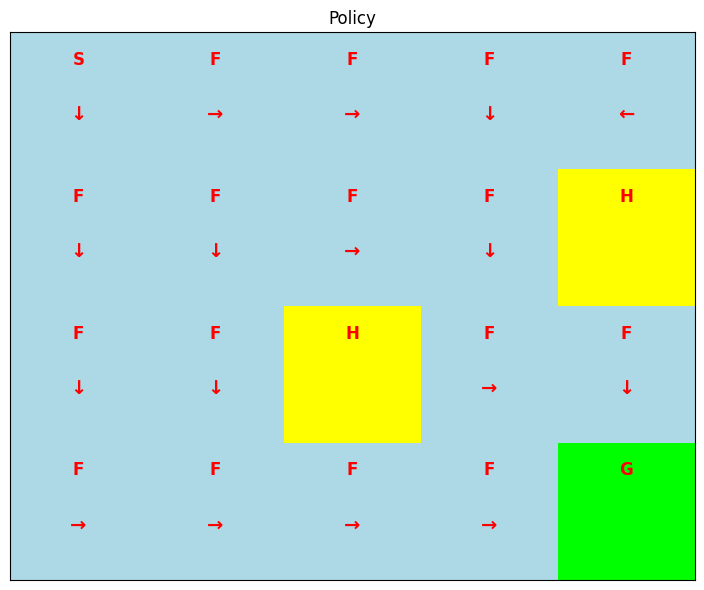

In [10]:
plot_policy(env,policy,V)

---------

# ${\color{pink}\mathbb{Policy-Iteration}}$

##### ${\color{pink}\mathbb{Prepiratuon}}$

$$ V^{\pi}(s) = \sum_{s'} P(s, \pi(s), s') \left[ R(s, \pi(s), s') + \gamma V^{\pi}(s') \right] $$

$$ Q^{\pi}(s, a) = \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma V^{\pi}(s') \right] $$


$$ \pi_{n+1}(s) = \arg\max_{a} Q^{\pi_n}(s, a) $$

In [11]:
def compute_vpi(P, policy, n_states, gamma=0.9):

    P_pi = np.zeros((n_states, n_states))           # Initialize transition matrix and reward vector
    R_pi = np.zeros(n_states)

    for s in range(n_states):
        a = policy[s]
        for prob, next_state, reward, done in P[s][a]:
            P_pi[s, next_state] += prob
            R_pi[s] += prob * reward

    I = np.eye(n_states)
    A = I - gamma * P_pi
    b = R_pi

    V = np.linalg.solve(A, b)
    return V

#    Compute the exact state-value function V^pi for a given policy using linear algebra.
#-  
#    - P: transition probabilities (env.unwrapped.P)
#    - policy: policy array of shape (n_states,)
#    - n_states: number of states
#    - gamma: discount factor
#    - V: exact value function under the policy
#----


#        a = policy[s]  # Current action under policy for state s

def compute_qpi(P, V, n_states, n_actions, gamma=0.9):
    Q = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a in range(n_actions):  # Evaluate Q for all actions, not just policy[s]
            for prob, next_state, reward, _ in P[s][a]:
                Q[s, a] += prob * (reward + gamma * V[next_state])
    return Q


#  Improve the policy using the state-action value function Q.
#  Q: state-action value function Q^pi
#  policy_stable: whether the policy changed
#----


def policy_iteration_with_q(P, n_states, n_actions, gamma=0.9, threshold = 1e-6 , max_iterations=100000):
    policy = np.random.choice(n_actions, size=n_states)

    for iteration in range(max_iterations):
         
        V = compute_vpi(P, policy, n_states, gamma)         # V^pi
        

        Q = compute_qpi(P, V, n_states, n_actions, gamma)   # Q^pi
        
        # Improve policy
        new_policy = np.argmax(Q, axis=1)
        stable = np.array_equal(new_policy, policy)

        if stable:
            break
        policy = new_policy
    else:
        print(" Policy iteration did not converge within the iteration limit.")     #so that i won;t run until infinty
    return policy, V

-----

In [12]:
env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)

P = env.unwrapped.P
n_states = env.observation_space.n    
n_actions = env.action_space.n


#  policy iteration to get optimal policy
optimal_policy, optimal_V = policy_iteration_with_q(P, n_states, n_actions)

env.close()

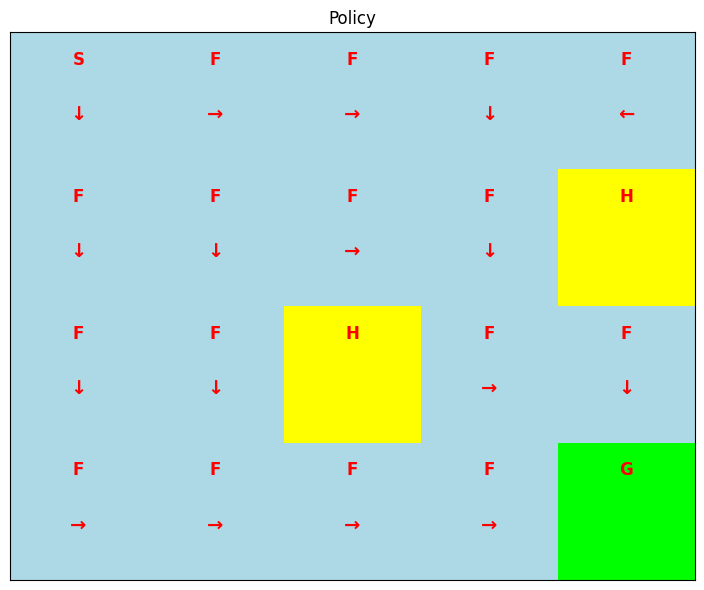

In [13]:
plot_policy(env,optimal_policy,optimal_V)

------

---

## ${\color{pink}\mathbb{10x10}}$

In [16]:
class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, map_name="4x5", is_slippery=True, slip_prob=0.2):
        self.map_name = map_name
        self.is_slippery = is_slippery
        self.slip_prob = slip_prob


        self.desc = np.asarray(generate_random_map(size=10, p=0.8), dtype="c")

        self.nrow, self.ncol = self.desc.shape
        self.nA = 4
        self.nS = self.nrow * self.ncol

        self.P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        self._init_transitions()

        self.observation_space = Discrete(self.nS)
        self.action_space = Discrete(self.nA)

        self.reset()

    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == 0:  # left
            col = max(col - 1, 0)
        elif a == 1:  # down
            row = min(row + 1, self.nrow - 1)
        elif a == 2:  # right
            col = min(col + 1, self.ncol - 1)
        elif a == 3:  # up
            row = max(row - 1, 0)
        return (row, col)

    def _init_transitions(self):
        for row in range(self.nrow):
            for col in range(self.ncol):
                s = self.to_s(row, col)
                for a in range(self.nA):
                    li = self.P[s][a]
                    letter = self.desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if self.is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                newrow, newcol = self.inc(row, col, b)
                                newstate = self.to_s(newrow, newcol)
                                newletter = self.desc[newrow, newcol]
                                done = bytes(newletter) in b"GH"
                                rew = self.get_tile_reward(newletter)       #to change for custom rewards...
                                prob = (
                                    self.slip_prob / 2 if b != a else 1 - self.slip_prob
                                )
                                li.append((prob, newstate, rew, done))
                        else:
                            newrow, newcol = self.inc(row, col, a)
                            newstate = self.to_s(newrow, newcol)
                            newletter = self.desc[newrow, newcol]
                            done = bytes(newletter) in b"GH"
                            rew = float(newletter == b"G")
                            li.append((1.0, newstate, rew, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = 0
        return self.s, {}

    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, s, rew, done = transitions[i]
        self.s = s
        return s, rew, done, False, {}
    
    def get_tile_reward(self,tile):
    
        if tile == b'S':
            return -0.08  
        elif tile == b'F':
            return -0.08  
        elif tile == b'H':
            return -1.0
        elif tile == b'G':
            return 1.0
        else:
            return -10  
    

In [17]:
gym.envs.registration.register(
        id="CustomFrozenLake-v0",
        entry_point=__name__ + ":CustomFrozenLakeEnv",
    )

c:\Users\matan\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:644: UserWarning: WARN: Overriding environment CustomFrozenLake-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [18]:
env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)

P = env.unwrapped.P
n_states = env.observation_space.n    
n_actions = env.action_space.n


actions = list(range(n_actions))
V = value_iteration(P, n_states, actions, gamma=0.9, threshold=1e-6)

#policy = get_optimal_action(P, V, n_states, actions, gamma=0.9)
policy = np.array([
    get_optimal_action(P, V, s, actions, gamma=0.9)
    for s in range(n_states)
])


env.close()

In [20]:
policy

array([2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 3, 3, 1, 1, 0, 2, 1, 0, 1, 0, 0, 0,
       2, 2, 2, 1, 1, 0, 1, 0, 1, 2, 3, 3, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 2, 2,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 3, 3, 0, 2, 2, 2, 2, 2, 0], dtype=int64)

In [19]:
plot_policy(policy,P,V)

AttributeError: 'numpy.ndarray' object has no attribute 'unwrapped'